In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import sys
sys.path.append('../src/')

from utils import DEFAULT_PALETTE
from WADParser import WAD_file
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from utils import EXMY_REGEX, MAPS_ATTRS
import struct
import re
from copy import deepcopy

In [18]:
w = WAD_file('../WADs/DOOM.WAD')

2025-02-15 00:34:42.483 | INFO     | WADParser:__init__:19 - IWAD found at ../WADs/DOOM.WAD
2025-02-15 00:34:42.483 | INFO     | WADParser:_get_palette:91 - Palette extracted.
2025-02-15 00:34:42.483 | INFO     | WADParser:_parse_levels:119 - 36 levels found in this WAD.
2025-02-15 00:34:42.483 | INFO     | WADParser:_parse_by_markers:149 - 107 FLATS found in this WAD.
2025-02-15 00:34:42.483 | INFO     | WADParser:_parse_by_markers:149 - 764 SPRITES found in this WAD.


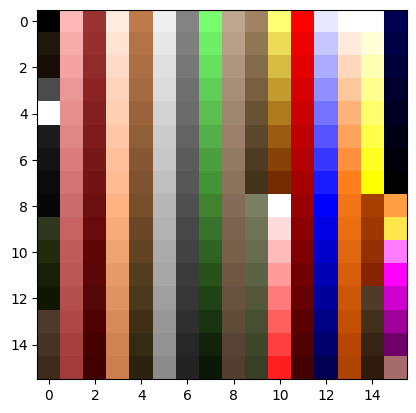

In [19]:
pal_idxs = np.arange(0, 256, 1).reshape((16, 16))

plt.imshow(w.palette[pal_idxs.T] / 255)


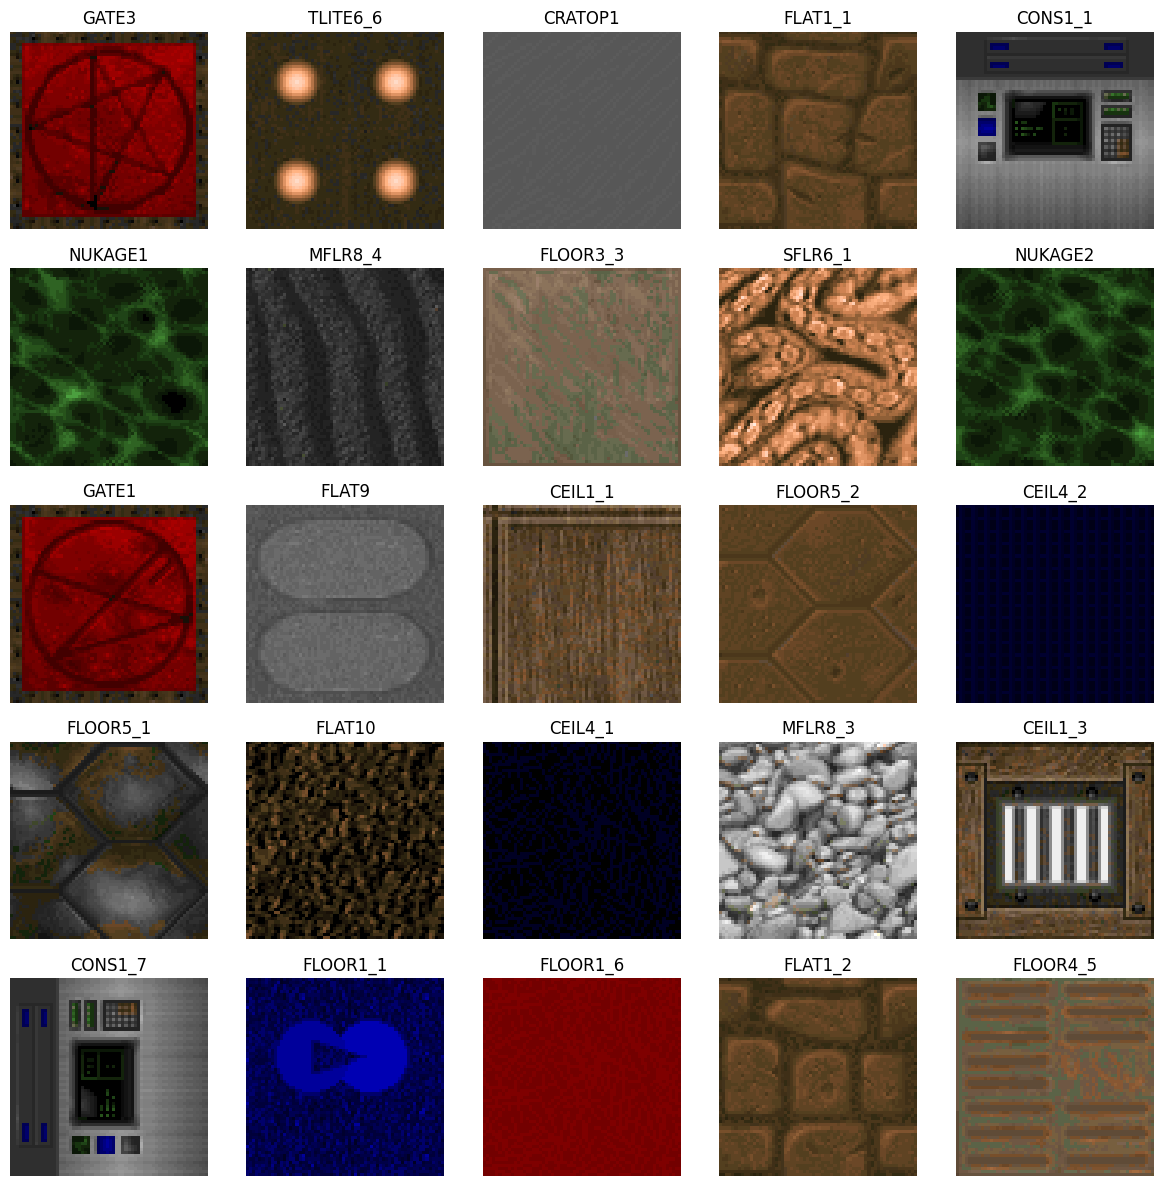

In [20]:
n_flats = 25
fig, ax = plt.subplots(5, 5, figsize=(12, 12))
ax = ax.ravel()

all_flat_names = list(w.flats.keys())
selected_flats = np.random.choice(all_flat_names, size=n_flats, replace=False)

for i, flat_name in enumerate(selected_flats):

    rgb_image = w.draw_flat(*w.flats[flat_name])

    ax[i].imshow(rgb_image / 255, aspect='equal')
    ax[i].set_title(flat_name)
    ax[i].axis('off')

fig.tight_layout(pad=1.2)

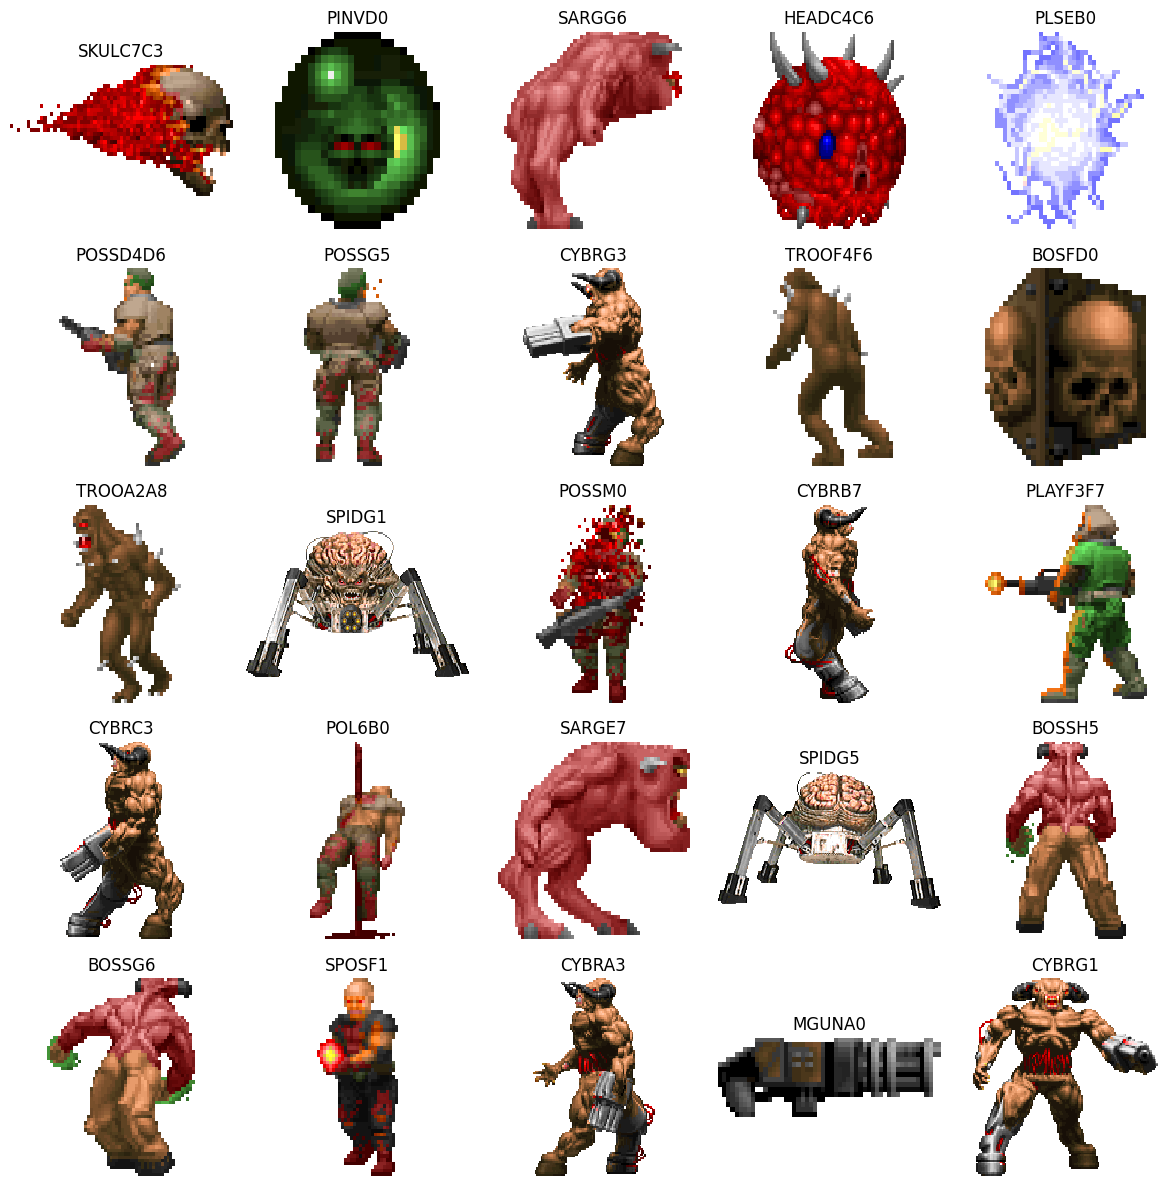

In [21]:
n_sprites = 25
fig, ax = plt.subplots(5, 5, figsize=(12, 12))
ax = ax.ravel()

all_sprite_names = list(w.sprites.keys())
selected_sprites = np.random.choice(all_sprite_names, size=n_sprites, replace=False)

for i, sprite_name in enumerate(selected_sprites):

    rgb_image = w.draw_patch(*w.sprites[sprite_name])

    # Original DOOM had non-square pixels!
    ax[i].imshow(rgb_image / 255, aspect=1.2, interpolation='nearest') 
    ax[i].set_title(sprite_name)
    ax[i].axis('off')

fig.tight_layout(pad=1.2)